<a href="https://colab.research.google.com/github/maxigaarp/teaching/blob/master/SpikeDesafio_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio Spike:

Link:
https://github.com/SpikeLab-CL/desafio_spike_energia_public

# Indicaciones Post-Entrega:

Me gustó el desafio, me entretuve con las primeras partes y deje poco tiempo para los puntos finales (que supongo eran los mas importantes). Me gustaría aclarar que:

*   No separé el dataset entre entrenamiento y testeo porque lo iba a dejar para el final. Sin embargo debido a que el set de datos es mucho mas grande comparado con los parametros de los modelos que usé es poco probable el overfitting.
*   En el entrenamiento de la red LSTM con los datos del clima se me olvidó llevar el dataset al intervalo [0,1], esto es crucial sin embargo se me olvido.
*   Deseo terminar bien el desafio, pero para no salirme de las reglas crearé un archivo adicional para modificarlo.




In [1]:
%%capture

#descargando datos 

!wget https://storage.googleapis.com/sistema_electrico_chile/demanda_real.csv
!wget https://storage.googleapis.com/sistema_electrico_chile/costo_marginal_real.csv
!wget https://storage.googleapis.com/sistema_electrico_chile/costo_marginal_programado.csv
!wget https://storage.googleapis.com/sistema_electrico_chile/base_para_prediccion.csv
!wget https://storage.googleapis.com/sistema_electrico_chile/datos_clima.csv



# 1. Costos marginales

Acá se inicializaran las variables y se mezclaran las bases de datos con el objetivo de usarlas a futuro


In [75]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#carga csv

demanda = pd.read_csv("demanda_real.csv")
cMarginal_real = pd.read_csv("costo_marginal_real.csv")
cMarginal_prog = pd.read_csv("costo_marginal_programado.csv")
bm = pd.read_csv("base_para_prediccion.csv")
datos_clima = pd.read_csv("datos_clima.csv")



---

Segun lo comentado en Gitter, existen datos duplicados en el costo programado. Puede deberse a un error de escritura, recalculo o algo mas. Con el objetivo de no eliminar el dato se calcula el promedio entre los dos. 

Por otro lado existen barras sin etiquetar, estas las borramos de la base de datos para no generar problemas

Finalmente, no se guarda el nombre de la barra ya que es un dato que posee la base de datos de los costos reales.

---



In [ ]:
cMarginal_prog=cMarginal_prog.groupby(["mnemotecnico_barra", "fecha", "hora"])["costo"].mean().rename("cmg_prog").reset_index()
cMarginal_prog.drop(cMarginal_prog[cMarginal_prog["mnemotecnico_barra"]=="-"].index, axis=0, inplace=True)
cMarginal_prog

,mnemotecnico_barra,fecha,hora,cmg_prog
4345,BA01G004SE001T011,2019-01-01,1,50.116286
4346,BA01G004SE001T011,2019-01-01,2,50.522836
4347,BA01G004SE001T011,2019-01-01,3,50.119505
4348,BA01G004SE001T011,2019-01-01,4,49.854087
4349,BA01G004SE001T011,2019-01-01,5,49.854087
...,...,...,...,...
1003890,BA99L117SE054L117,2019-06-30,20,46.800602
1003891,BA99L117SE054L117,2019-06-30,21,48.607941
1003892,BA99L117SE054L117,2019-06-30,22,48.537587
1003893,BA99L117SE054L117,2019-06-30,23,47.783023


---
El costo marginal real no tiene duplicados, sin embargo con la idea de hacer un merge con la db anterior cambiamos algunos nombres de columnas

---



In [ ]:
cMarginal_real=cMarginal_real.rename(columns={"barra_mnemotecnico": "mnemotecnico_barra", "costo_en_dolares": "cmg_real"})
cMarginal_real

,mnemotecnico_barra,barra_referencia_mnemotecnico,fecha,hora,cmg_real,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1
...,...,...,...,...,...,...,...
4309946,BA04G065SE002G065,BA02T002SE032T002,2019-01-23,24,76.38,51.35944,BA S/E LA LAJA ENERGIA COYANCO BARRA 110KV
4309947,BA03R003SE023R003,BA02T002SE032T002,2019-01-23,24,87.71,58.97796,BA S/E SAN SEBASTIAN BARRA 66KV N° 1
4309948,BA01T005SE050T005,BA02T002SE032T002,2019-01-23,24,89.58,60.23538,BA S/E LICANTEN 66KV
4309949,BA01G111SE001G111,BA02T002SE032T002,2019-01-23,24,76.30,51.30565,BA S/E CENTRAL SANTA MARTA 220KV


In [ ]:
costo_marginal = pd.merge(cMarginal_prog,cMarginal_real, on=["mnemotecnico_barra", "fecha", "hora"])

In [ ]:
costo_marginal

,mnemotecnico_barra,fecha,hora,cmg_prog,barra_referencia_mnemotecnico,cmg_real,costo_en_pesos,nombre
0,BA01G004SE001T011,2019-01-01,1,50.116286,BA02T002SE032T002,50.41,35.06973,BA S/E CANDELARIA B1 - 220KV
1,BA01G004SE001T011,2019-01-01,2,50.522836,BA02T002SE032T002,50.41,35.06973,BA S/E CANDELARIA B1 - 220KV
2,BA01G004SE001T011,2019-01-01,3,50.119505,BA02T002SE032T002,49.40,34.36709,BA S/E CANDELARIA B1 - 220KV
3,BA01G004SE001T011,2019-01-01,4,49.854087,BA02T002SE032T002,48.56,33.78271,BA S/E CANDELARIA B1 - 220KV
4,BA01G004SE001T011,2019-01-01,5,49.854087,BA02T002SE032T002,46.51,32.35654,BA S/E CANDELARIA B1 - 220KV
...,...,...,...,...,...,...,...,...
900924,BA99L117SE054L117,2019-06-30,20,46.800602,BA02T002SE032T002,47.79,32.49051,BA S/E COLLAHUASI 220KV-BP1
900925,BA99L117SE054L117,2019-06-30,21,48.607941,BA02T002SE032T002,47.79,32.49051,BA S/E COLLAHUASI 220KV-BP1
900926,BA99L117SE054L117,2019-06-30,22,48.537587,BA02T002SE032T002,47.79,32.49051,BA S/E COLLAHUASI 220KV-BP1
900927,BA99L117SE054L117,2019-06-30,23,47.783023,BA02T002SE032T002,47.79,32.49051,BA S/E COLLAHUASI 220KV-BP1


---
Podria ser buena idea pasar la fecha y la hora a un solo dato, sin embargo 
revisando la DB nos damos cuenta que existe la hora 25 y un dia tiene 23 horas. Lo cual corresponde a los dias de cambio de hora. La solución seria pasarlo todo a hora GMT, sin embargo se pierde la regularidad en el gasto energetico de las empresas que es causado por los horarios de trabajo. Se opta por dejarlo tal cual se encuentra y se ordena según fecha y hora.

---


## Analisis exploratorio de datos



In [ ]:
print("Numero de barras con costo programado:")
print(cMarginal_prog["mnemotecnico_barra"].nunique() )
print("Numero de barras totales:")
print(cMarginal_real["mnemotecnico_barra"].nunique() )


Numero de barras con costo programado:
238
Numero de barras totales:
1020


In [ ]:
#barras con costo programado que no aparecen su cmg real

s = set(cMarginal_prog["mnemotecnico_barra"].unique())- set(cMarginal_real["mnemotecnico_barra"].unique())
print(len(s))
s

18


{'BA01G006SE002G006',
 'BA01L011SE009L011',
 'BA01L011SE027L011',
 'BA01L011SE028L011',
 'BA01L050SE001T002',
 'BA01R002SE050R002',
 'BA02G004SE017G004',
 'BA02R002SE007R002',
 'BA02T002SE012T002',
 'BA02T003SE002T003',
 'BA02T003SE029T003',
 'BA03R002SE010R002',
 'BA04R002SE014R002',
 'BA05T005SE005T005',
 'BA06T002SE008T002',
 'BA08T002SE003T002',
 'BA16T002SE009T002',
 'BA22L120SE114L120'}

In [ ]:
print("Porcentaje:")
print((cMarginal_prog["mnemotecnico_barra"].nunique()-len(s))/cMarginal_real["mnemotecnico_barra"].nunique()*100 )


Porcentaje:
21.568627450980394


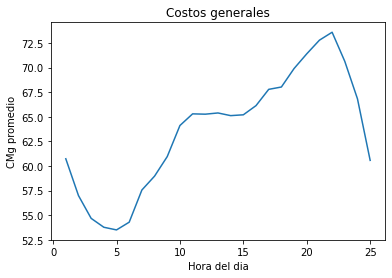

In [ ]:
plt.plot(range(1,26), cMarginal_real.groupby(["hora"])["cmg_real"].mean()) 
plt.xlabel('Hora del dia')
plt.ylabel('CMg promedio')
plt.title('Costos generales')

plt.show()

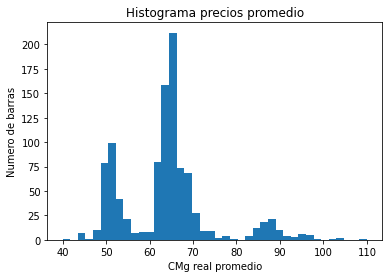

In [ ]:
plt.hist(cMarginal_real.groupby(["mnemotecnico_barra"])["cmg_real"].mean(),bins=40, range=[40, 110]) # rango para ignorar los de cmg = 0
plt.xlabel('CMg real promedio')
plt.ylabel('Numero de barras')
plt.title('Histograma precios promedio')

plt.show()


In [ ]:
means_global=cMarginal_real.groupby(["mnemotecnico_barra"]).mean()["cmg_real"]
sum(means_global==0)

## Numero de barras con costos marginales iguales a 0

5

In [ ]:

means_global=cMarginal_real.groupby(["mnemotecnico_barra"]).transform("mean")["cmg_real"] #metodo lento, seria mejor con apply

intervalo1 = cMarginal_real[means_global<=60]
intervalo2 = cMarginal_real[(means_global>=60) & (means_global<=80)]
intervalo3 = cMarginal_real[means_global>=80]

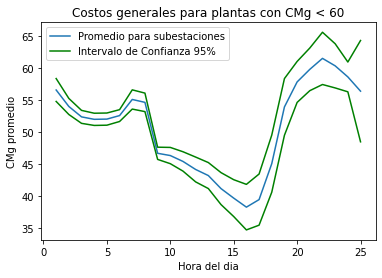

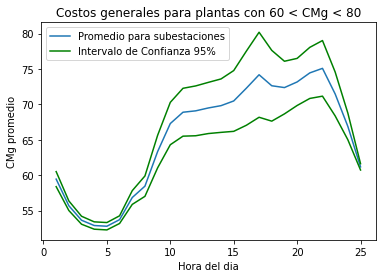

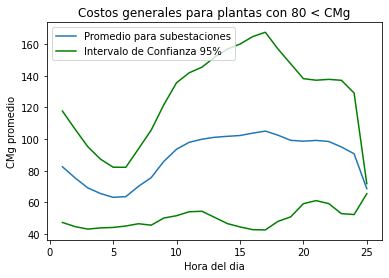

In [ ]:
db_stations=[intervalo1,intervalo2,intervalo3]
conditions=["CMg < 60", "60 < CMg < 80", "80 < CMg"]

for i in range(3):
  db=db_stations[i]
  mean=db.groupby(["hora"])["cmg_real"].mean()
  var=db.groupby(["hora"])["cmg_real"].var()
  n=db.groupby(["hora"])["cmg_real"].count()
  
  intervalo_confianza_arriba=mean +1.96*var/np.sqrt(n) 
  intervalo_confianza_abajo=mean -1.96*var/np.sqrt(n) 

  plt.plot(range(1,26), mean, label="Promedio para subestaciones")
  plt.plot(range(1,26), intervalo_confianza_arriba, label='Intervalo de Confianza 95%', color="green")
  plt.plot(range(1,26), intervalo_confianza_abajo, color="green")
  plt.xlabel('Hora del dia')
  plt.ylabel('CMg promedio')
  plt.title('Costos generales para plantas con '+ conditions[i])
  plt.legend(loc='upper left')

  plt.show()

Basado en los graficos y calculos anteriores podemos ver que:

*  **Porcentaje total de barras con el costo programado son el 21.6%**. Además existen 18 barras que no poseen datos de Costos marginales reales.

*   Los costos marginales calzan con la **clasica doble montura** en los costos marginales de la electricidad (existe un pequeño peak en la mañana y el peak grande a las 20 hrs)

*   Podemos calcular los costos marginales (reales) por cada subestacion y vemos varias particularidades. En particular, en el histograma podemos ver que existen 3 grandes concentraciones de barras con costos marginales parecidos. **Diremos que son 3 "tipos" de plantas, las de CMg menor a 60, entre 60 y 80  y finalmente las de costos mayores a 80**. Además hay 5 barras con costos cercanos al 0 que deben ignorarse. 

*   En base a esta subdivision analizamos los costos marginales de cada uno de los tipos de plantas, además graficamos el intervalo de confianza para cada una de ellas. Vemos que todas tienen sus particularidades: 

  **En primer lugar vemos que las de $ CMg< 60$** tienen, al contrario de la curva de costos general, una baja en el periodo de la tarde. Esto podria corresponder a plantas de **energia solar** (con mayor capacidad dentro de las horas de la tarde)** y eolica **(fuentes de energia mucho mas variable)

  **Las de $60 < CMg < 80$ replican la curva de CMg global**, en particular tienen un intervalo de confianza muy cercano a la media. Por esto podriamos decir que son plantas con costos mas estables como las **termoelectricas**.

  **Finalmente las de $CMg > 80$** tambien replica la curva de CMg global, sin embargo el intervalo de confianza supera por mucho a los otros dos tipos de estaciones. Por esto me inclino a pensar que son **estaciones de "encendido rapido", estas son centrales a gas y diesel** que poseen costos altos pero pueden empezar a funcionar rapidamente (a diferencia de las termoelectricas que demoran 1 hora en encender). Estas centrales se usan para ayudar a regular el sistema electrico, es decir cuando la oferta y demanda son muy distintas.





# 2. Construcción de variables


Construiremos variables de desviacion: 

Como en algunos casos exite $CMg_{prog}=0$ la desviacion porcentual se irá a infinito lo que es un problema. Para esos casos reemplazaremos los valores infinitos por NaN (por ahora)



In [ ]:
costo_marginal["desviación"] = costo_marginal["cmg_prog"] - costo_marginal["cmg_real"]
costo_marginal["desviación_pct"] = costo_marginal["desviación"]/costo_marginal["cmg_prog"]*100
costo_marginal=costo_marginal.replace([np.inf, -np.inf], np.nan)

costo_marginal["desviacion_cat"] =  (costo_marginal["desviación_pct"]<=-15) | (costo_marginal["desviación_pct"]>=15)


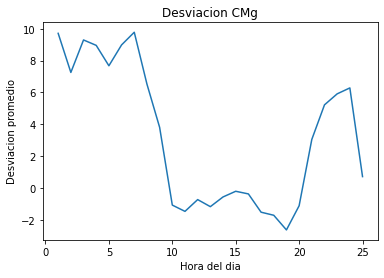

In [ ]:
plt.plot(range(1,26), costo_marginal.groupby(["hora"])["desviación"].mean()) 
plt.xlabel('Hora del dia')
plt.ylabel('Desviacion promedio')
plt.title('Desviacion CMg')

plt.show()

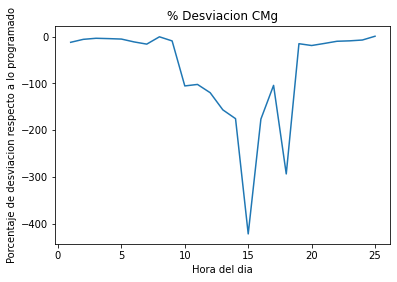

In [ ]:
plt.plot(range(1,26), costo_marginal.groupby(["hora"])["desviación_pct"].mean()) 
plt.xlabel('Hora del dia')
plt.ylabel('Porcentaje de desviacion respecto a lo programado')
plt.title('% Desviacion CMg')

plt.show()

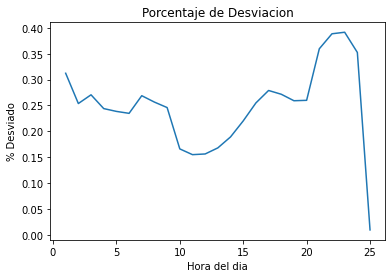

In [ ]:
plt.plot(range(1,26), costo_marginal.groupby(["hora"])["desviacion_cat"].mean()) 
plt.xlabel('Hora del dia')
plt.ylabel('% Desviado')
plt.title('Porcentaje de Desviacion')

plt.show()

La variable categorica de desviacion (desviacion_cat) es una variable booleana que representa si es que en un instante de tiempo el costo marginal real y el programado son muy distintos (más de un 15%). Además de esto podemos ver que:

*   Por lo general en la tarde (de 10 a 19 hrs) el CMg real es mayor a lo programado

*   Durante estas horas tambien las desviaciones porcentuales son grandes (gran variabilidad)

*   El porcentaje de desviacion (cantidad de veces que el existe desviacion dentro de una hora) permanece bastante constante a lo largo del dia, con una pequeña baja en la tarde y una alza en la noche.




# 3. Visualización de datos

Creacion de la funcion:

Por simplicidad voy a eliminar del plot la "hora 25" en los dias de cambio de hora.



In [ ]:
import matplotlib.pyplot as plt

costo_marginal["datetime"]= pd.to_datetime(costo_marginal["fecha"]+ " "+((costo_marginal["hora"]-1)%24).astype(str)+ ":00:00" )

def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):

  dat=costo_marginal[(costo_marginal["mnemotecnico_barra"]==codigo_barra) & (costo_marginal['fecha'] >= fecha_inicial) & (costo_marginal['fecha'] <= fecha_final)].copy()
  plt.plot(dat.datetime, dat.cmg_prog, label="CMg programado")
  plt.plot(dat.datetime, dat.cmg_real, label="CMg real")
  plt.xticks( rotation='vertical')
  plt.legend()
  plt.xlabel('Dia')
  plt.ylabel('Precio')
  plt.title("CMg barra "+  codigo_barra)
  plt.show()



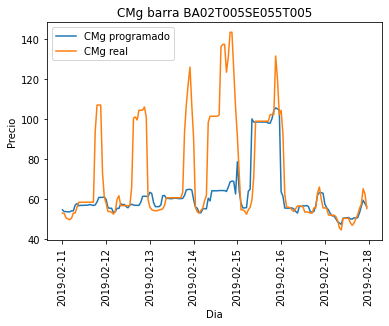

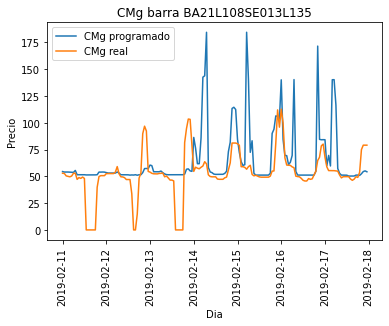

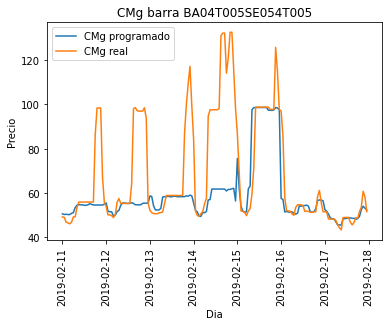

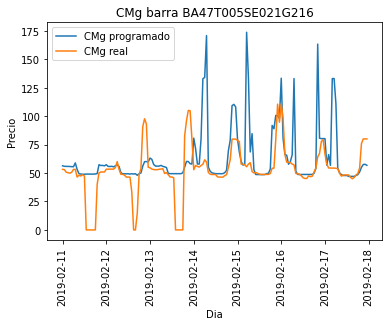

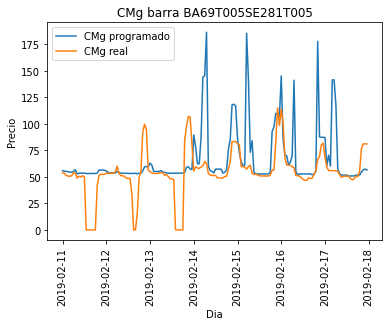

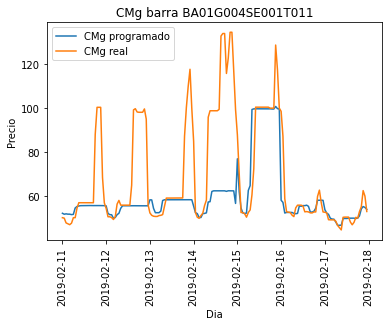

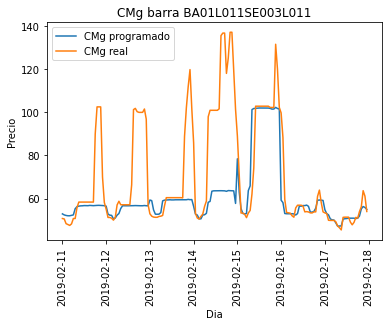

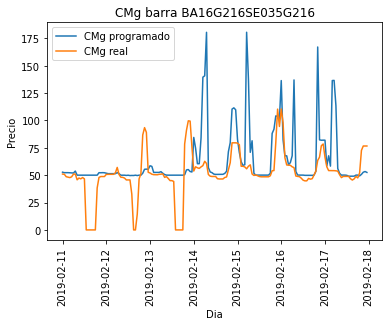

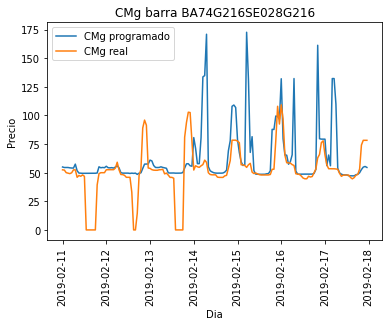

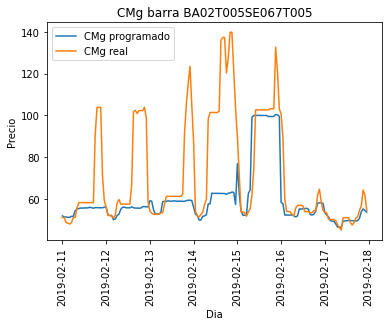

In [ ]:
barras=costo_marginal["mnemotecnico_barra"].unique()
n_show=10
np.random.seed(3)

muestra= np.random.choice(barras, n_show)

for codigo_barra in muestra:
  time_plot_costo_barra(codigo_barra, "2019-02-11", "2019-02-17")




---



**Qué puedes concluir de estos plots?**

Vemos que existe un valor base para la mayoria de las plantas, debe ser el costo marginal bajo condiciones normales, en baja carga o "de encendido". Ademas notamos otras barras que tienen costos marginales programados y reales muy escalonados (cuadrados, con abruptas subidas y luego estables por un periodo de tiempo), estas deben ser termoelectricas ya que por lo general estas se programan para permanecer prendidas durante un gran periodo de tiempo.

Además se puede ver que existen algunas tendencias diarias que se repiten, los valores se mantienen estables en la noche.

Una de las cosas mas notables es que muchas barras tienen comportamientos similares entre si, esto puede deberse a la cercania entre ellas (deben alimentar la misma demanda y se reparten la carga) o que son subestaciones dentro de un grupo mas grande (pero esto no podria asegurarlo hasta tener mas informacion de cada una)


---



In [ ]:
# se elimina barra con costo marginal medio igual a 0

costo_marginal.drop(costo_marginal[costo_marginal.groupby(["mnemotecnico_barra"])["cmg_real"].transform("mean")==0].index, axis=0, inplace=True)

# 4. Base para los modelos

Ahora creare las variables y realizare un breve analisis del subset. Ya tengo cargado el dataset bajo nombre "bm"

Carga la base base_para_predicción.csv. Esta será la base principal para las siguientes preguntas.

En rasgos generales, ¿Qué puedes decir de los datos? (dimensiones, tipo de datos, variables categóricas, variables numéricas, fechas).

A partir de la variable fecha, crea nuevas variables para el año, mes, semana del año, dia del calendario, dia de la semana y una variable que indique si el dia corresponde a un día de semana o fin de semana. Estas features/variables te servirán para entrenar el modelo.

Implementa una función que para una subestación y una variable, grafique múltiples series de tiempo diarias correspondientes a una lista de fechas. Para esto, la función debe recibir como argumentos: código de una subestación, una variable (serie numérica), y una lista de fechas (año-mes-día). Por ejemplo: para la subestación SE005T002 y la variable gen_solar_total_mwh, la función debe graficar los perfiles diarios de generación solar por hora para las fechas '2019-01-10', '2019-02-10' y '2019-03-10'.

Grafica la curva de generación solar, por hora, en la subestación SE005T002 para las fechas del 10, 11, 12, 13 y 14 de enero de 2019. Haz lo mismo para la subestación SE127T005. Que podrías decir, en términos generales, sobre la generación solar y las dos subestaciones mencionadas, basados en estos dos gráficos?

Grafica la curva de generación térmica, por hora, en la subestación SE020G213 para los días 14, 15, 16 y 17 de mayo de 2019. Haz lo mismo para la subestación SE106G216. Que podrías decir, en términos generales, sobre la generación térmica en esta subestación con respecto a este gráfico?






In [ ]:
bm.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


In [ ]:
print("Numero codigos:")
print(bm["nemotecnico_se"].nunique())
print("Dia inicio, fin:")
print(bm.fecha.min()[:10]+ " a " + bm.fecha.max()[:10])
print("Promedio de la cantidad de dias por barra:")
print(bm.groupby(["nemotecnico_se"])["fecha"].nunique().mean())

print("Total de barras: (?)")
print(bm.groupby(["nemotecnico_se"])["n_barras"].mean().sum())

Numero codigos:
29
Dia inicio, fin:
2019-01-01 a 2019-06-30
Promedio de la cantidad de dias por barra:
162.0
Total de barras: (?)
67


In [ ]:
bm.groupby(["nemotecnico_se"])["fecha"].nunique()

nemotecnico_se
SE001T002    181
SE003T011    181
SE004L079    181
SE004T002    181
SE005R002    181
SE005T002    181
SE005T003    181
SE008G010    181
SE009G004    181
SE009T002    181
SE014T002    181
SE015R002    181
SE019T002    181
SE020G213     91
SE028T002    181
SE031G216      4
SE036T002    181
SE039R002    181
SE055T002    181
SE055T005    181
SE067T005    181
SE071T005    157
SE081T005    157
SE082T005    157
SE103L123      1
SE106G216    149
SE123G216    181
SE127T005    181
SE170T005    181
Name: fecha, dtype: int64



---


Por ahora podemos ver que el dataset es de 29 codigos de subestaciones (muy parecido a lo que teniamos antes con las barras, pero en este caso quizas se agruparon algunas de ellas, de ahi vendria la variable n_barras). La cantidad de barras seria (creo) la suma de las barras para cada codigo lo que nos daria un total de 67.

Notemos tambien que el periodo comprendido es del primer semestre 2019, la mayoria poseen datos de 181, sin embargo hay 3 codigos con 157 dias, uno 149 otro con 149 y otro con 91 dias. Existen ademas dos codigos con muy pocos dias registrados uno con 4 y otro con solo 1 dia.

Los datos de CMg prog y real espero que sean similares a los vistos en las secciones anteriores asi que no los analizare por ahora. 

Aparece la generacion de cada barra donde se especifica la fuente de cada generador, 5 tipos de energia son analizados. Vemos la demanda electrica por dia para cada subestacion (sin embargo dudo que las unidades sean MWh) y la capacidad instalada de generacion para cada subestacion.

---



In [76]:
bm["fecha"] = pd.to_datetime(bm["fecha"]).dt.tz_localize(None) #limpio la fecha 


In [77]:
bm["day"] = bm["fecha"].dt.day
bm["year"] = bm["fecha"].dt.year
bm["month"] = bm["fecha"].dt.month
bm["week"] = bm["fecha"].dt.isocalendar().week
bm["dayofweek"] = bm["fecha"].dt.dayofweek
bm["weekend"] = (bm["dayofweek"] >= 5).astype("int")



Ahora implemento la funcion para plotear variables. Se usa en el mismo ejemplo que se da en el desafio.

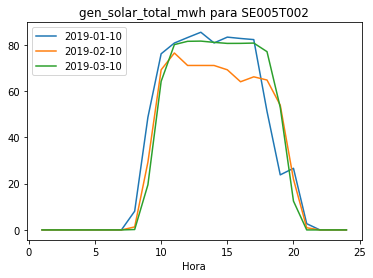

In [ ]:
def plot_subestacion(codigo_se, variable, fechas):
  dat=bm[(bm["nemotecnico_se"]==codigo_se)][[variable,"hora","fecha"]]
  for dia in fechas:
    datdia=dat[dat['fecha']==dia].sort_values(by=["hora"])
    plt.plot(datdia["hora"], datdia[variable], label= dia)
  plt.legend()
  plt.xlabel('Hora')

  plt.title(variable + " para "+ codigo_se)

  plt.show()

codigo_se = "SE005T002"
variable = "gen_solar_total_mwh"
fechas = ['2019-01-10', '2019-02-10',  '2019-03-10']
plot_subestacion(codigo_se, variable, fechas)

**Grafica la curva de generación solar, subestación SE005T002 y SE127T005 para las fechas del 10, 11, 12, 13 y 14 de enero de 2019.**

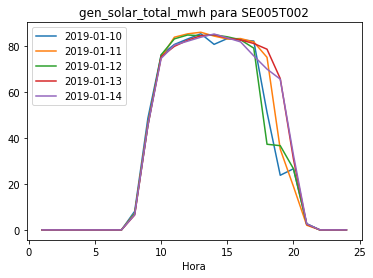

In [ ]:
plot_subestacion("SE005T002","gen_solar_total_mwh", ["2019-01-"+str(i) for i in range(10,15)])

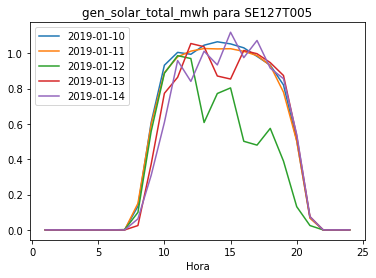

In [ ]:
plot_subestacion("SE127T005","gen_solar_total_mwh", ["2019-01-"+str(i) for i in range(10,15)])

**Q: Que podrías decir, en términos generales, sobre la generación solar y las dos subestaciones mencionadas, basados en estos dos gráficos?**


---


Son estaciones de generacion solar, la variabilidad de generacion esta dada por las nubes y es un factor externo, fuera del control de la subestacion. La primera casi no se vio afectada, excepto durante la tarde noche en algunos dias, la segunda se vio afectada por nubes el dia 12, y un poco durante las tardes.

---



**Grafica la curva de generación térmica, por hora, en la subestación SE020G213 y SE106G216 para los días 14, 15, 16 y 17 de mayo de 2019. .** 

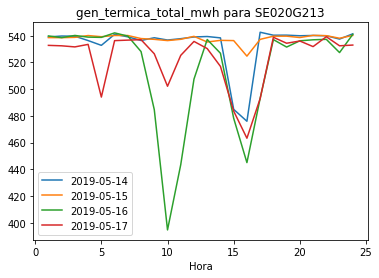

In [ ]:
plot_subestacion("SE020G213","gen_termica_total_mwh", ["2019-05-"+str(i) for i in range(14,18)])

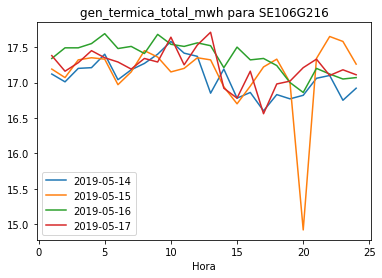

In [ ]:
plot_subestacion("SE106G216","gen_termica_total_mwh", ["2019-05-"+str(i) for i in range(14,18)])

**Que podrías decir, en términos generales, sobre la generación térmica en esta subestación con respecto a este gráfico?**

---
La generacion termica es mas estable a lo largo del dia, la primera que tiene una gran carga, practicamente permanece constante a lo largo de los 5 dias (excepto por grandes caidas en ciertos dias). La otra en cambio tiene mayores fluctuaciones, sin embargo es una planta mas pequeña.


---



# 5. Predicción de desviaciones del costo marginal: modelo 1



In [ ]:
bm.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,day,year,month,week,dayofweek,weekend
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785,4,2019,1,1,4,0
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785,4,2019,1,1,4,0
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785,4,2019,1,1,4,0
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785,4,2019,1,1,4,0
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785,4,2019,1,1,4,0


Una pequeña revision a la variable demanda_mwh

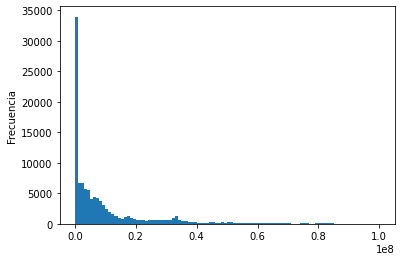

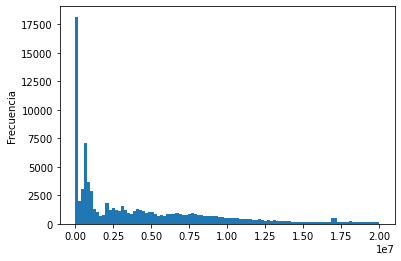

In [ ]:
plt.hist(bm["demanda_mwh"],bins=100,range=[0,1e8])
plt.ylabel("Frecuencia")
plt.show()

#Zoom
plt.hist(bm["demanda_mwh"],bins=100,range=[0,2e7])
plt.ylabel("Frecuencia")
plt.show()

## Modificaciones y variables nuevas
Voy a hacer las siguientes cosas:

*   Reemplazar los infinito por NaN en CMg_desv (despues de calcular la variable target)
*   Crear una variable categorica del tipo de energia (vimos previamente que influia podia influir bastante)
*   Calcular las medias y varianzas por hora y por subestacion de las variables: demanda, cmg_desv y en_total_mwh. Tambien la media por hora y por dia del cmg_desv
*   Crearé nuevas columnas para alojar la variable target en la siguiente hora y tambien las medias de cmg_desv de la siguiente hora (como son promedios voy a asumir que se encuentran disponibles en la hora previa). 





In [78]:
bm["target"] = ((bm["cmg_desv_pct"] <= -15 ) | (bm["cmg_desv_pct"] >= 15)).astype(int)
bm=bm.replace([np.inf, -np.inf], np.nan)


In [79]:
gens = ["gen_eolica_total_mwh",	"gen_geotermica_total_mwh",	"gen_hidraulica_total_mwh",	"gen_solar_total_mwh",	"gen_termica_total_mwh"]
gens_cats=[g+"_cat" for g in gens]

bm["en_total_mwh"]=bm[gens].sum(axis=1) ## se calcula la suma de todas las energías generadas en la subestacion

for g in gens:
  means=bm.groupby(["nemotecnico_se"])[g].mean()
  en_cat=(means.notna() & means!=0).astype("int").rename(g+"_cat").reset_index()
  bm=bm.merge(en_cat)

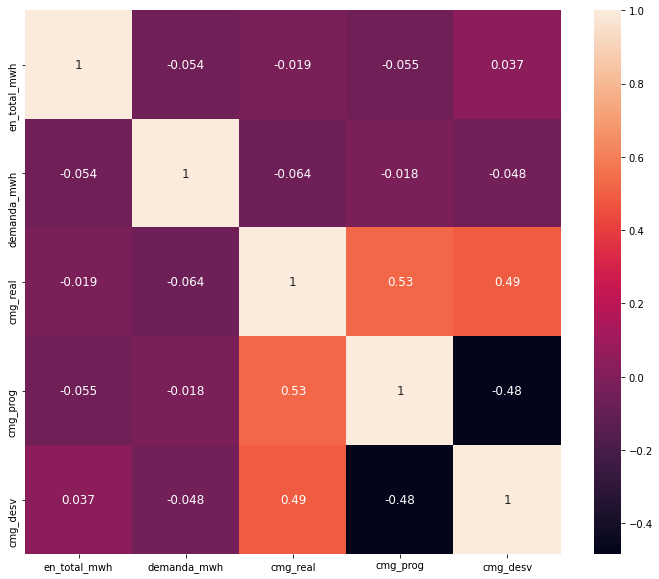

In [7]:
# correlaciones entre algunas variables 
import seaborn as sns

correlation=bm[["en_total_mwh", "demanda_mwh", "cmg_real",	"cmg_prog", "cmg_desv"]].corr()

fig,ax=plt.subplots(figsize=(12,10))
sns.heatmap(correlation,annot=True,annot_kws={'size': 12})


In [80]:
#medias y varianzas de variables

bm["cmg_desv_mean"]=bm.groupby(["nemotecnico_se", "hora"])["cmg_desv"].transform("mean") #media DesvCMg por subestacion por hora
bm["cmg_desv_var"]=bm.groupby(["nemotecnico_se", "hora"])["cmg_desv"].transform("var") #varianza DesvCMg por subestacion por hora

bm["demanda_mean"]=bm.groupby(["nemotecnico_se", "hora"])["demanda_mwh"].transform("mean") #media de demanda por hora
bm["demanda_var"]=bm.groupby(["nemotecnico_se", "hora"])["demanda_mwh"].transform("var") #varianza de demanda por hora

bm["en_total_mean"]=bm.groupby(["nemotecnico_se", "hora"])["en_total_mwh"].transform("mean") #media generacion por subestacion por hora
bm["en_total_var"]=bm.groupby(["nemotecnico_se", "hora"])["en_total_mwh"].transform("var") #varianza generacion por subestacion por hora

bm["target_prob"]=bm.groupby(["nemotecnico_se", "hora"])["target"].transform("mean") #probabilidad que en una hora dada la variable target este activada en SE
bm["target_var"]=bm.groupby(["nemotecnico_se", "hora"])["target"].transform("var") #varianza target por subestacion por hora

bm["cmg_desv_mean_global"]=bm.groupby(["fecha", "hora"])["cmg_desv"].transform("mean") #media DesvCMg por hora


In [ ]:
#se cambian las estadisticas a la siguiente hora

columns_to_shift=[ "cmg_desv_mean","cmg_desv_var", "target_var", "en_total_mean", "demanda_mean", 
                  "cmg_desv_mean_global", "target", "target_prob","cmg_desv" ]

# las ultimas dos las usaré como variables target (de la hora siguiente) cuando desarrolle los modelos
bm=bm.sort_values(by=["nemotecnico_se","fecha","hora"]).reset_index()

columns_shifted=[]

for col in columns_to_shift:
  col_next=col+"_next"
  bm[col_next] = bm.groupby('nemotecnico_se')[col].transform(lambda group: group.shift(-1))
  columns_shifted.append(col_next)

bm=bm.dropna(subset=columns_shifted) # se elimina el ultimo instante para cada barra ya que no posee un valor para el target siguiente

In [ ]:
bm.head()

,index,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,day,year,month,week,dayofweek,weekend,target,en_total_mwh,gen_eolica_total_mwh_cat,gen_geotermica_total_mwh_cat,gen_hidraulica_total_mwh_cat,gen_solar_total_mwh_cat,gen_termica_total_mwh_cat,cmg_desv_mean,cmg_desv_var,demanda_mean,demanda_var,en_total_mean,en_total_var,target_prob,target_var,target_prob_se,target_var_se,cmg_desv_mean_global,cmg_desv_mean_next,cmg_desv_var_next,target_var_next,en_total_mean_next,demanda_mean_next,cmg_desv_mean_global_next,target_next,target_prob_se_next,target_prob_next,cmg_desv_next
0,120,SE001T002,2019-01-01,1,NaN,NaN,NaN,0.0,0.0,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,1,2019,1,1,1,0,1,0.0,0,0,0,1,1,-16.111381,853.902599,1.450818e+09,1.700164e+18,0.0,0.0,0.419890,0.244936,0.268199,0.196310,-28.229231,-11.065304,444.466404,0.228177,0.0,1.421274e+09,-28.372244,1.0,0.213282,0.348066,-71.39
1,121,SE001T002,2019-01-01,2,NaN,NaN,NaN,0.0,0.0,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,1,2019,1,1,1,0,1,0.0,0,0,0,1,1,-11.065304,444.466404,1.421274e+09,1.358366e+18,0.0,0.0,0.348066,0.228177,0.213282,0.167829,-28.372244,-13.992376,553.898842,0.241989,0.0,1.306254e+09,0.126346,0.0,0.226266,0.403315,1.65
2,122,SE001T002,2019-01-01,3,NaN,NaN,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,1,2019,1,1,1,0,0,0.0,0,0,0,1,1,-13.992376,553.898842,1.306254e+09,1.210236e+18,0.0,0.0,0.403315,0.241989,0.226266,0.175107,0.126346,-14.254862,689.271394,0.229834,0.0,1.419248e+09,-0.575962,0.0,0.206897,0.353591,0.55
3,123,SE001T002,2019-01-01,4,NaN,NaN,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,1,2019,1,1,1,0,0,0.0,0,0,0,1,1,-14.254862,689.271394,1.419248e+09,1.315176e+18,0.0,0.0,0.353591,0.229834,0.206897,0.164125,-0.575962,-11.983481,505.176244,0.228177,0.0,1.360323e+09,-1.306026,0.0,0.202639,0.348066,1.77
4,124,SE001T002,2019-01-01,5,NaN,NaN,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,1,2019,1,1,1,0,0,0.0,0,0,0,1,1,-11.983481,505.176244,1.360323e+09,1.319732e+18,0.0,0.0,0.348066,0.228177,0.202639,0.161611,-1.306026,-14.624254,765.191312,0.232965,0.0,1.412636e+09,2.719808,0.0,0.196892,0.364641,0.55


Analizando las variables creadas vemos que no hay subestaciones de energia geotermica ni eolica. Borramos las columnas respectivas para que mezclarlas


In [ ]:
bm[gens_cats].sum()

gen_eolica_total_mwh_cat            0
gen_geotermica_total_mwh_cat        0
gen_hidraulica_total_mwh_cat    34168
gen_solar_total_mwh_cat         37935
gen_termica_total_mwh_cat       44940
dtype: int64

In [81]:
bm.drop(['gen_eolica_total_mwh', 'gen_geotermica_total_mwh', 'gen_eolica_total_mwh_cat', 'gen_geotermica_total_mwh_cat'], axis=1,inplace=True)

gens = ["gen_hidraulica_total_mwh",	"gen_solar_total_mwh",	"gen_termica_total_mwh"]
gens_cats=[g+"_cat" for g in gens]

In [ ]:
bm.head()

,index,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,day,year,month,week,dayofweek,weekend,target,en_total_mwh,gen_hidraulica_total_mwh_cat,gen_solar_total_mwh_cat,gen_termica_total_mwh_cat,cmg_desv_mean,cmg_desv_var,demanda_mean,demanda_var,en_total_mean,en_total_var,target_prob,target_var,target_prob_se,target_var_se,cmg_desv_mean_global,cmg_desv_mean_next,cmg_desv_var_next,target_var_next,en_total_mean_next,demanda_mean_next,cmg_desv_mean_global_next,target_next,target_prob_se_next,target_prob_next,cmg_desv_next
0,120,SE001T002,2019-01-01,1,NaN,0.0,0.0,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,1,2019,1,1,1,0,1,0.0,0,1,1,-16.111381,853.902599,1.450818e+09,1.700164e+18,0.0,0.0,0.419890,0.244936,0.268199,0.196310,-28.229231,-11.065304,444.466404,0.228177,0.0,1.421274e+09,-28.372244,1.0,0.213282,0.348066,-71.39
1,121,SE001T002,2019-01-01,2,NaN,0.0,0.0,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,1,2019,1,1,1,0,1,0.0,0,1,1,-11.065304,444.466404,1.421274e+09,1.358366e+18,0.0,0.0,0.348066,0.228177,0.213282,0.167829,-28.372244,-13.992376,553.898842,0.241989,0.0,1.306254e+09,0.126346,0.0,0.226266,0.403315,1.65
2,122,SE001T002,2019-01-01,3,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,1,2019,1,1,1,0,0,0.0,0,1,1,-13.992376,553.898842,1.306254e+09,1.210236e+18,0.0,0.0,0.403315,0.241989,0.226266,0.175107,0.126346,-14.254862,689.271394,0.229834,0.0,1.419248e+09,-0.575962,0.0,0.206897,0.353591,0.55
3,123,SE001T002,2019-01-01,4,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,1,2019,1,1,1,0,0,0.0,0,1,1,-14.254862,689.271394,1.419248e+09,1.315176e+18,0.0,0.0,0.353591,0.229834,0.206897,0.164125,-0.575962,-11.983481,505.176244,0.228177,0.0,1.360323e+09,-1.306026,0.0,0.202639,0.348066,1.77
4,124,SE001T002,2019-01-01,5,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,1,2019,1,1,1,0,0,0.0,0,1,1,-11.983481,505.176244,1.360323e+09,1.319732e+18,0.0,0.0,0.348066,0.228177,0.202639,0.161611,-1.306026,-14.624254,765.191312,0.232965,0.0,1.412636e+09,2.719808,0.0,0.196892,0.364641,0.55


## Metricas y preparacion del dataset

In [68]:
#scores para las matrices de confusion

def scores(smat): 
    tp = smat[0][0] 
    fp = smat[0][1] 
    fn = smat[1][0] 
    tn = smat[1][1] 

    ac = (tp+tn)/(tp+fp+tn+fn)
    pr = tp/(tp+fp)
    rc = tp/(tp+fn)
    f1= 2*pr*rc/(pr+rc)
    print("Accuracy: "+ str(ac) +"\nPrecision: "+ str(pr) +"\nRecall: "+ str(rc) +"\nF1: "+ str(f1)+"\n")
    return ac,pr,rc,f1


Limpio los datos, elimino las filas con datos NaN que vaya a usar para el modelo. Para ello voy seleccionar primero las features que deseo incluir.

Tomaremos el total de features posibles y luego seleccionaremos las que produzcan mejores resultados. 

In [ ]:
features_sets=[gens_cats, ["weekend"], ["demanda_mwh","demanda_mean", "en_total_mwh", "en_total_var"],
          ["cmg_desv_pct"], ["cmg_desv", "cmg_desv_mean_next", 	"cmg_desv_var"], ["target", "target_prob_next", "target_var"] ]

total_features= sum(features_sets, [])  

bm=bm.dropna(subset=total_features) # se eliminan las filas con valores NAN en cualquiera de las features, esto se puede mejorar?: si, pero es mas enredado


### Dataset

In [ ]:
print("Porcentaje de 1's en variable target: "+str((bm["target_next"]).sum()/len(bm["target_next"])))

Porcentaje de 1's en variable target: 0.2528134762851463


Equilibramos las dos clases: es decir seleccionamos variables target con valores 0 y 1 

In [ ]:
targets_sample=bm[bm["target_next"]==1].index
n_targets=len(targets_sample)

targets_sample=targets_sample.append(pd.Index(np.random.choice(bm[bm["target_next"]==0].index,n_targets)))

##  Modelo 1 v1

Intentaremos usar un modelo simple de regresion logistica por el momento. Agregaremos como variable explicativa la booleana target (del momento actual) para predecir la del instante siguiente

In [ ]:

import itertools 
def findsubsets(s, n): 
    return [set(i) for i in itertools.combinations(s, n)]

def power_set(s):
    return sum([findsubsets(s, n) for n in range(1,len(s)+1) ],[])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(solver='liblinear', random_state=0)

mix_features_len= len(features_sets)

y=np.array(bm["target_next"][targets_sample])

mix_features=power_set(range(mix_features_len))

all_scores=[]

for mix in mix_features:
    features_picked=sum([features_sets[s] for s in mix], [])
    X=np.array([bm[f][targets_sample]/bm[f].max() for f in features_picked]).transpose()
    print("Modelo con las features:  \n "+  ' '.join(features_picked))
    model.fit(X, y)
    cm=confusion_matrix(y, model.predict(X))
    _ ,_, _, x= scores(cm)
    all_scores.append(x)

Modelo con las features:  
 gen_hidraulica_total_mwh_cat gen_solar_total_mwh_cat gen_termica_total_mwh_cat
Accuracy: 0.5384061786905389
Precision: 0.3249429524311041
Recall: 0.5670178877726048
F1: 0.4131312905889442

Modelo con las features:  
 weekend
Accuracy: 0.5500087765490609
Precision: 0.31349833245567843
Recall: 0.5948970754779828
F1: 0.41061247011219426

Modelo con las features:  
 demanda_mwh demanda_mean en_total_mwh en_total_var
Accuracy: 0.5315078111286642
Precision: 0.18715113217482884
Recall: 0.6012179993233338
F1: 0.2854465624330692

Modelo con las features:  
 cmg_desv_pct
Accuracy: 0.5259083728278041
Precision: 0.9983149025803054
Recall: 0.5133217805696957
F1: 0.6780158077321984

Modelo con las features:  
 cmg_desv cmg_desv_mean_next cmg_desv_var
Accuracy: 0.6268386870282605
Precision: 0.7611023345620502
Recall: 0.5999889300935407
F1: 0.6710100744363113

Modelo con las features:  
 target target_prob_next target_var
Accuracy: 0.8331578023521151
Precision: 0.9046866771

In [ ]:
mix=mix_features[np.argmax(all_scores)] # extraigo el mix de features que tuvo mejor score F1

features_picked=sum([features_sets[s] for s in mix], [])
X=np.array([bm[f][targets_sample]/bm[f].max() for f in features_picked]).transpose()
print("Modelo con las features:  \n "+  ' '.join(features_picked))
model.fit(X, y)
cm=confusion_matrix(y, model.predict(X))
scores(cm)


Modelo con las features:  
 weekend demanda_mwh demanda_mean en_total_mwh en_total_var target target_prob_next target_var
Accuracy: 0.8335264174126733
Precision: 0.9038792346849219
Recall: 0.7923860523805127
F1: 0.8444684968349241



(0.8335264174126733,
 0.9038792346849219,
 0.7923860523805127,
 0.8444684968349241)

Mejor modelo (segun score F1 ) corresponde al que tiene las features: 

 weekend demanda_mwh demanda_mean en_total_mwh en_total_var target target_prob_next target_var


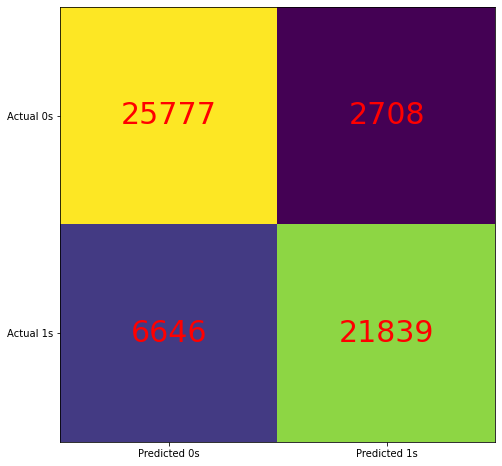

In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=30)
plt.show()

Voy a programar lo mismo en Statsmodels, lo bueno de este package es que analiza todo de manera estadistica asi que me entrega los valores de las significancias.

In [ ]:
import statsmodels.api as sm

y=np.array(bm["target_next"][targets_sample])
X=np.array([bm[f][targets_sample]/bm[f].max() for f in features_picked]).transpose()

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()
result.summary2()


Optimization terminated successfully.
         Current function value: 0.415008
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.401     
Dependent Variable: y                AIC:              47304.0090
Date:               2020-10-01 20:40 BIC:              47384.5615
No. Observations:   56970            Log-Likelihood:   -23643.   
Df Model:           8                LL-Null:          -39489.   
Df Residuals:       56961            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -1.7916     0.0481   -37.2254   0.0000   -1.8859   -1.6973
x1       -0.3710     0.0268   -13.8255   0.0000   -0.4236   -0.3184
x2        1.4465     0.4088     3.5384   0.0004    0.6453    2.2478
x3       -0.1644     0.1064    -1.5444   0.1225   -0.3730    0.0442
x4        0.2305     0.1122     2.0546   0.0399    0.0106    0.4503
x5       -0.1829     0.1255    -1.4577   0.1449   -0.4289    0.0630
x6        3.4444     0.0265   129.9088   0.0000    3.3924    3.4963
x7        6.5853     0.1888    34.8750   0.0000    6.2152    6.9554
x8       -2.1538     0.1489   -14.4608   0.0000   -2.4457   -1.8619
=================================================================

"""

In [ ]:
cm= result.pred_table()
scores(cm)

Accuracy: 0.8342636475337897
Precision: 0.9004388274530455
Recall: 0.7951945434816308
F1: 0.8445505432993086



(0.8342636475337897,
 0.9004388274530455,
 0.7951945434816308,
 0.8445505432993086)

Existen diferencias entre statsmodels y sklearn debido a las diferencias entre los packages y los metodos de resolucion.

Podemos ver que la variable mas importante del modelo es "target" (tiene mayor valor Z), es decir lo mas importante para el modelo con el fin de predecir la desviacion del momento siguiente es la desviacion actual.

Necesitariamos hacer pruebas con distintas combinaciones para ver la mas indicada. (no lo hare)

## Modelo 1 v2

Usemos redes neuronales ahora, veamos si podemos mejorar el resultado.



In [12]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
features=features_picked

y=np.array(bm["target_next"][targets_sample])
X=np.array([bm[f][targets_sample]/bm[f].max() for f in features]).transpose()


model = Sequential()
model.add(Dense(12, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=30, batch_size=32)


Epoch 1/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4415 - accuracy: 0.8258
Epoch 2/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4163 - accuracy: 0.8337
Epoch 3/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4155 - accuracy: 0.8336
Epoch 4/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4147 - accuracy: 0.8335
Epoch 5/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4142 - accuracy: 0.8335
Epoch 6/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4136 - accuracy: 0.8338
Epoch 7/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4130 - accuracy: 0.8338
Epoch 8/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4125 - accuracy: 0.8332
Epoch 9/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4121 - accuracy: 0.8342
Epoch 10/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.411

In [ ]:
y_pred = model.predict_classes(X)
cm=confusion_matrix(y, y_pred)

scores(cm)


Accuracy: 0.8358083201685097
Precision: 0.904932420572231
Recall: 0.7950220522468618
F1: 0.8464241150587772



(0.8358083201685097, 0.904932420572231, 0.7950220522468618, 0.8464241150587772)



---


**Ahora voy a intentar con todas las variables**

---



In [ ]:
features=sum(features_sets,[])

y=np.array(bm["target_next"][targets_sample])
X=np.array([bm[f][targets_sample]/bm[f].max() for f in features]).transpose()


model = Sequential()
model.add(Dense(16, input_dim=len(features), activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=50, batch_size=32)


Epoch 1/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4464 - accuracy: 0.8180
Epoch 2/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4167 - accuracy: 0.8341
Epoch 3/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4137 - accuracy: 0.8343
Epoch 4/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4114 - accuracy: 0.8339
Epoch 5/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4100 - accuracy: 0.8337
Epoch 6/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4086 - accuracy: 0.8341
Epoch 7/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4071 - accuracy: 0.8344
Epoch 8/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4061 - accuracy: 0.8345
Epoch 9/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.4048 - accuracy: 0.8351
Epoch 10/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.403

In [ ]:
y_pred = model.predict_classes(X)
cm=confusion_matrix(y, y_pred)

scores(cm)


Precision: 0.8799017026505178
Recall: 0.8229577094825322
F1: 0.850477596240308



(0.8799017026505178, 0.8229577094825322, 0.850477596240308)

Notamos que el modelo de redes neuronales mejora un poco el resultado, sin embargo tampoco es mucho. En estos casos suele ser conveniente quedarse con el modelo de regresion logistica ya que es mas facil de entender.



## Modelo 1 v3

Ahora hare un modelo de una red neuronal LSTM (Long Short-Term Memory), este tipo de redes neuronales estan especializadas en prediccion de series de tiempo ya que guardan una "memoria" a corto plazo sobre los resultados pasados. En otras palabras logran modelar el hecho de que un resultado depende del siguiente y asi sucesivamente.

Sinceramente creo que es mejor modelar la red LSTM para predecir la desviacion del costo marginal y con esto calcular la variable target, sin embargo hacer esto involucraria mas trabajo

---



In [47]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


In [ ]:
bm.head()

,index,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,day,year,month,week,dayofweek,weekend,target,en_total_mwh,gen_hidraulica_total_mwh_cat,gen_solar_total_mwh_cat,gen_termica_total_mwh_cat,cmg_desv_mean,cmg_desv_var,demanda_mean,demanda_var,en_total_mean,en_total_var,target_prob,target_var,target_prob_se,target_var_se,cmg_desv_mean_global,cmg_desv_mean_next,cmg_desv_var_next,target_var_next,en_total_mean_next,demanda_mean_next,cmg_desv_mean_global_next,target_next,target_prob_se_next,target_prob_next,cmg_desv_next
0,120,SE001T002,2019-01-01,1,NaN,0.0,0.0,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,1,2019,1,1,1,0,1,0.0,0,1,1,-16.111381,853.902599,1.450818e+09,1.700164e+18,0.0,0.0,0.419890,0.244936,0.268199,0.196310,-28.229231,-11.065304,444.466404,0.228177,0.0,1.421274e+09,-28.372244,1.0,0.213282,0.348066,-71.39
1,121,SE001T002,2019-01-01,2,NaN,0.0,0.0,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,1,2019,1,1,1,0,1,0.0,0,1,1,-11.065304,444.466404,1.421274e+09,1.358366e+18,0.0,0.0,0.348066,0.228177,0.213282,0.167829,-28.372244,-13.992376,553.898842,0.241989,0.0,1.306254e+09,0.126346,0.0,0.226266,0.403315,1.65
2,122,SE001T002,2019-01-01,3,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,1,2019,1,1,1,0,0,0.0,0,1,1,-13.992376,553.898842,1.306254e+09,1.210236e+18,0.0,0.0,0.403315,0.241989,0.226266,0.175107,0.126346,-14.254862,689.271394,0.229834,0.0,1.419248e+09,-0.575962,0.0,0.206897,0.353591,0.55
3,123,SE001T002,2019-01-01,4,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,1,2019,1,1,1,0,0,0.0,0,1,1,-14.254862,689.271394,1.419248e+09,1.315176e+18,0.0,0.0,0.353591,0.229834,0.206897,0.164125,-0.575962,-11.983481,505.176244,0.228177,0.0,1.360323e+09,-1.306026,0.0,0.202639,0.348066,1.77
4,124,SE001T002,2019-01-01,5,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,1,2019,1,1,1,0,0,0.0,0,1,1,-11.983481,505.176244,1.360323e+09,1.319732e+18,0.0,0.0,0.348066,0.228177,0.202639,0.161611,-1.306026,-14.624254,765.191312,0.232965,0.0,1.412636e+09,2.719808,0.0,0.196892,0.364641,0.55


In [ ]:
def create_dataset(features,  look_back=1):
  print("Este metodo toma su tiempo")

  codigos_se=bm["nemotecnico_se"].unique()
  dataX, dataY = [], []

  for se in codigos_se:
    dat_filter=bm[bm["nemotecnico_se"]==se].sort_values(by=["fecha","hora"]).reset_index()
    num_data=len(dat_filter)

    for i in range(num_data-look_back-1):
      a = dat_filter[i:(i+look_back)][features]
      dataX.append(np.array(a))
      dataY.append(dat_filter.iloc[i + look_back]["target"])
  return np.array(dataX), np.array(dataY)


features=["target", "target_prob_next", "weekend"]

look_back=2
trainX, trainY = create_dataset(features,look_back)


Este metodo toma su tiempo


In [ ]:
targets_sample=np.where(trainY==1)[0]
n_targets=len(targets_sample)

targets_sample=pd.Index(np.append(targets_sample,np.random.choice(np.where(trainY==0)[0],n_targets))

trainX2=trainX[targets_sample]
trainY2=trainY[targets_sample]

In [ ]:

# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 12, input_shape=(2,3)))
model.add(Dropout(0.2))
model.add(Dense(12,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, trainY, epochs=20, batch_size=32)


Epoch 1/20
3519/3519 [==============================] - 8s 2ms/step - loss: 0.3719 - accuracy: 0.8643
Epoch 2/20
3519/3519 [==============================] - 9s 2ms/step - loss: 0.3517 - accuracy: 0.8739
Epoch 3/20
3519/3519 [==============================] - 8s 2ms/step - loss: 0.3504 - accuracy: 0.8739
Epoch 4/20
3519/3519 [==============================] - 9s 2ms/step - loss: 0.3479 - accuracy: 0.8743
Epoch 5/20
3519/3519 [==============================] - 9s 2ms/step - loss: 0.3460 - accuracy: 0.8749
Epoch 6/20
3519/3519 [==============================] - 9s 2ms/step - loss: 0.3448 - accuracy: 0.8756
Epoch 7/20
3519/3519 [==============================] - 9s 2ms/step - loss: 0.3443 - accuracy: 0.8756
Epoch 8/20
3519/3519 [==============================] - 9s 2ms/step - loss: 0.3442 - accuracy: 0.8756
Epoch 9/20
3519/3519 [==============================] - 8s 2ms/step - loss: 0.3431 - accuracy: 0.8757
Epoch 10/20
3519/3519 [==============================] - 9s 2ms/step - loss: 0.343

In [ ]:
y_pred = model.predict_classes(X_train)
cm=confusion_matrix(trainY, y_pred)

scores(cm)

Accuracy: 0.8779798912850393
Precision: 0.9255688437670891
Recall: 0.912379590784447
F1: 0.918926893751623



(0.8779798912850393, 0.9255688437670891, 0.912379590784447, 0.918926893751623)

## Conclusiones de los modelos

El score en el que uno se fija depende de el uso al que se le quiere dar al modelo. Si es importante la antelacion de los instantes en que existe desviacion puede ser util fijarse en la Accuracy (cuantos datos fueron correctamente clasificados), sin embargo como no sabemos que es lo que queremos propongo fijarme en el score F1. Este indice mezcla la precision (razon correctamente clasificada como positiva) y el recall (proporcion de los positivos que se clasifico como positiva), la media geometrica de estos dos valores es el score F1 que se usa mucho en problemas de clasificacion. 

A los modelos les va mas o menos en la prediccion, la variable CMg_desv y su version porcentual son muy inciertas lo que hace dificil el problema. El mejor resultado (en base a creo que todas las metricas) fue el resultado de la red neuronal LSTM. 

La variable más util para el modelo fue variable target en el instante anterior, despues de eso, la media de la variable target en el instante siguiente parece ser importante segun nos dice el modelo de regresion logistica.

# 6. Predicción de desviaciones del costo marginal: modelo 2


**Q: Ahora imagina que te dicen que, en producción, te enviarán datos actualizados del sistema cada 12 horas. ¿Cuál debiese ser tu target a predecir en ese caso? Explica.**

Debemos intentar predecir la desviacion para las siguientes 12 horas, sin embargo esto puede llegar a ser complicado debido a la falta de feedback al modelo. Si tenemos problemas para predecir la hora siguiente, es una locura intentar predecir para las siguientes 12 horas. Sería bueno (y una carga bastante menor de trabajo) basarse en estadisticas horarias para los instantes mas alejados de tus datos.


Si antes nuestra variable target era $t_{i+1}$ en este caso seria $(t_{i+j}), j=1,...,12$

Existirian 2 formas de desarrollar este problema, la primera es ingresar todos los datos que pueden resultar utiles y esperar que las redes neuronales sepan distinguir cual valor es util y cual no o hacer un modelo distinto con la informacion que se sabe funcionará mejor. Ejemplo del segundo caso es, si es que quiero predecir el target para los instante 13,...24, el valor medio del target en el instante 13 no tiene porque afectar al calculo del target en el instante 24.

En honor al tiempo prefiero hacerlo de la primera forma, es decir pasarle el vector completo de los promedios de los targets.



In [91]:
bm.head()

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,day,year,month,week,dayofweek,weekend,target,en_total_mwh,gen_hidraulica_total_mwh_cat,gen_solar_total_mwh_cat,gen_termica_total_mwh_cat,cmg_desv_mean,cmg_desv_var,demanda_mean,demanda_var,en_total_mean,en_total_var,target_prob,target_var,cmg_desv_mean_global,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,SE031G216,2019-01-04,1,NaN,NaN,0.0,56.2,55.627852,0.763454,1.02,2,1210767,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-1.2600,2.803000,1278236.75,3.405506e+09,0.0,0.0,0.00,0.000000,0.531859,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
1,SE031G216,2019-01-04,2,NaN,NaN,0.0,56.2,55.376645,0.763793,1.48,2,113232,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-1.5250,8.928700,939003.00,3.039391e+11,0.0,0.0,0.00,0.000000,0.731603,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
2,SE031G216,2019-01-04,3,NaN,NaN,0.0,56.2,59.531891,0.758166,-5.59,2,1089415,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-3.3200,17.336333,1153312.00,3.538295e+09,0.0,0.0,0.00,0.000000,-1.000449,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
3,SE031G216,2019-01-04,4,NaN,NaN,0.0,56.2,174.378923,0.602435,-67.77,2,1096867,13.20785,4,2019,1,1,4,0,1,0.0,0,0,1,-32.0400,3314.744867,1162386.00,4.365182e+09,0.0,0.0,0.25,0.250000,-44.559936,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
4,SE031G216,2019-01-04,5,NaN,NaN,0.0,56.2,172.820310,0.604551,-67.48,2,1071851,13.20785,4,2019,1,1,4,0,1,0.0,0,0,1,-44.8475,3063.158625,1166277.00,7.700343e+09,0.0,0.0,0.50,0.333333,-44.711026,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47


In [ ]:
features=["target","cmg_desv", "weekend"]
features_laged=["target_prob", "target_var"]

#to scale
to_scale=["cmg_desv"]


for f in to_scale:
  minval=bm[f].min()
  maxval=bm[f].max()
  bm[f] = (bm[f]-minval)/(maxval-minval) 

In [92]:
lag=12
look_back=12

features=["target","cmg_desv", "weekend"]
features_laged=["target_prob", "target_var"]

print("Este metodo toma su tiempo")

codigos_se=bm["nemotecnico_se"].unique()

dataX, dataY = [], []
for se in codigos_se:
  dat_filter=bm[bm["nemotecnico_se"]==se].sort_values(by=["fecha","hora"]).reset_index()
  num_data=len(dat_filter)
  for i in range(num_data-look_back-lag):
    a = dat_filter[i:(i+look_back)][features]
    b = dat_filter[(i+ lag):(i+look_back+ lag)][features_laged]

    dataX.append(np.hstack((np.array(a), np.array(b))))
    dataY.append(dat_filter[(i+lag): (i+ look_back+lag)]["target"])

  print(se) 

dataX=np.array(dataX)
dataY=np.array(dataY)

Este metodo toma su tiempo
SE031G216
SE001T002
SE003T011
SE004L079
SE004T002
SE005R002
SE005T002
SE005T003
SE008G010
SE009G004
SE009T002
SE014T002
SE015R002
SE019T002
SE020G213
SE028T002
SE036T002
SE039R002
SE055T002
SE055T005
SE067T005
SE071T005
SE081T005
SE082T005
SE106G216
SE123G216
SE127T005
SE170T005


Acá creo la base de datos, notese que selecciono para cada instante de tiempo los 12 datos pasados de "target","cmg_desv", "weekend" y los 12 datos futuros de "target_prob", "target_var" de este modo tiene datos utiles a la hora de clasificar


In [93]:

# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, input_shape=(12,5)))
model.add(Dropout(0.2))
model.add(Dense(40,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(dataX, dataY, epochs=20, batch_size=32)



Epoch 1/20
3502/3502 [==============================] - 22s 6ms/step - loss: 0.4901 - accuracy: 0.2169
Epoch 2/20
3502/3502 [==============================] - 23s 7ms/step - loss: 0.4769 - accuracy: 0.2261
Epoch 3/20
3502/3502 [==============================] - 23s 6ms/step - loss: 0.4726 - accuracy: 0.2262
Epoch 4/20
3502/3502 [==============================] - 23s 7ms/step - loss: 0.4698 - accuracy: 0.2292
Epoch 5/20
3502/3502 [==============================] - 23s 6ms/step - loss: 0.4672 - accuracy: 0.2303
Epoch 6/20
3502/3502 [==============================] - 23s 7ms/step - loss: 0.4648 - accuracy: 0.2282
Epoch 7/20
3502/3502 [==============================] - 24s 7ms/step - loss: 0.4623 - accuracy: 0.2290
Epoch 8/20
3502/3502 [==============================] - 24s 7ms/step - loss: 0.4606 - accuracy: 0.2269
Epoch 9/20
3502/3502 [==============================] - 24s 7ms/step - loss: 0.4579 - accuracy: 0.2269
Epoch 10/20
3502/3502 [==============================] - 24s 7ms/step - l

In [ ]:
y_pred = model.predict(dataX)
y_pred_classes= np.around(y_pred)

results= dataY== y_pred_classes

accuracy_1a1 = np.sum(results)/(12*len(y_pred))

print("Accuracy hora a hora: "+str(accuracy_1a1))


Accuracy hora a hora: 0.8481071428571428


Notemos que como estamos haciendo una comparacion de 12 horas seguidas es complicado establecer el score en el que nos fijaremos. ¿Es acaso la falla en una sola hora del dia un fallo? la red neuronal ve la comparacion del vector completo, es decir si la prediccion se realiza correctamente para las 12 horas, el resultado:

**El 23% de los instantes de tiempo se predice correctamente las 12 hora a futuro**

**Por otro lado si hacemos una test de accuracy para cada una de las horas por separado obtenemos un 84.8%**


# 7. Merge con datos de clima: modelo 3


In [82]:
datos_clima = pd.read_csv("datos_clima.csv")

datos_clima["fecha"] = pd.to_datetime(datos_clima["fecha"]).dt.tz_localize(None) #limpio la fecha 
datos_clima=datos_clima.rename(columns={"subestacion": "nemotecnico_se"})

datos_clima

,fecha,nemotecnico_se,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,2019-05-06,SE019T002,-28.470641,-71.252694,2.00,0.31,0.00,74.66,16.39,11.94,19.01,13.93,1.78,16.62,4.14,4.93,2.81,5.01,6.23,3.50
1,2019-05-21,SE005T003,-42.626987,-73.805673,2.00,0.54,0.01,92.82,5.55,4.45,9.39,3.32,0.77,6.50,2.64,2.94,2.04,4.20,4.94,3.55
2,2019-02-28,SE005T003,-42.626987,-73.805673,2.00,0.21,2.35,88.87,12.25,10.45,15.64,9.61,2.34,12.44,2.62,3.77,1.78,4.16,5.68,2.85
3,2019-01-08,SE004T002,-39.549899,-72.912208,2.00,0.16,5.96,92.22,9.52,8.30,10.88,7.90,1.62,10.17,2.70,4.02,1.67,4.96,6.87,2.97
4,2019-05-07,SE003T011,-35.685919,-71.377335,2.00,0.37,0.00,44.02,13.57,1.49,20.38,9.57,1.05,11.34,1.69,3.58,0.65,2.25,4.42,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5244,2019-06-03,SE067T005,-34.119671,-70.753847,1.81,0.39,0.00,37.03,11.94,-2.41,20.67,6.78,0.60,7.71,1.97,3.04,0.50,2.51,3.95,0.49
5245,2019-05-30,SE082T005,-30.690328,-70.954981,1.81,0.34,1.23,83.22,3.02,0.45,7.44,0.31,0.96,3.38,3.46,6.87,1.71,4.35,7.19,2.61
5246,2019-05-07,SE008G010,-32.749506,-71.481002,1.81,0.31,0.01,60.68,14.95,7.48,21.80,10.45,1.56,15.52,2.37,3.96,0.84,2.72,4.29,0.67
5247,2019-06-09,SE003T011,-35.685919,-71.377335,1.81,0.42,0.00,46.51,8.77,-2.12,15.99,5.62,0.78,5.31,1.17,2.54,0.17,1.59,2.93,0.25


In [83]:
bm = pd.merge(bm,datos_clima, on=["nemotecnico_se", "fecha"])

In [84]:
bm.head()

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,day,year,month,week,dayofweek,weekend,target,en_total_mwh,gen_hidraulica_total_mwh_cat,gen_solar_total_mwh_cat,gen_termica_total_mwh_cat,cmg_desv_mean,cmg_desv_var,demanda_mean,demanda_var,en_total_mean,en_total_var,target_prob,target_var,cmg_desv_mean_global,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,SE031G216,2019-01-04,1,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-1.2600,2.803000,1278236.75,3.405506e+09,0.0,0.0,0.00,0.000000,0.531859,-18.467444,-70.303497,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
1,SE031G216,2019-01-04,2,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-1.5250,8.928700,939003.00,3.039391e+11,0.0,0.0,0.00,0.000000,0.731603,-18.467444,-70.303497,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
2,SE031G216,2019-01-04,3,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-3.3200,17.336333,1153312.00,3.538295e+09,0.0,0.0,0.00,0.000000,-1.000449,-18.467444,-70.303497,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
3,SE031G216,2019-01-04,4,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785,4,2019,1,1,4,0,1,0.0,0,0,1,-32.0400,3314.744867,1162386.00,4.365182e+09,0.0,0.0,0.25,0.250000,-44.559936,-18.467444,-70.303497,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
4,SE031G216,2019-01-04,5,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785,4,2019,1,1,4,0,1,0.0,0,0,1,-44.8475,3063.158625,1166277.00,7.700343e+09,0.0,0.0,0.50,0.333333,-44.711026,-18.467444,-70.303497,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47


Utilizare para el entrenamiento solo las variables :

"ALLSKY_SFC_SW_DWN",	"KT",	"PRECTOT",	"RH2M",	"T2M"

Esto porque representan el clima a grandes rasgos

In [85]:
features=["target","cmg_desv", "weekend"]
features_laged=["target_prob", "target_var", "ALLSKY_SFC_SW_DWN",	"KT",	"PRECTOT",	"RH2M",	"T2M"]

#to scale
to_scale=["cmg_desv", "ALLSKY_SFC_SW_DWN",	"KT",	"PRECTOT",	"RH2M",	"T2M"]


for f in to_scale:
  minval=bm[f].min()
  maxval=bm[f].max()
  bm[f] = (bm[f]-minval)/(maxval-minval) 

In [86]:
bm=bm.dropna(subset=features+features_laged) 

In [87]:
bm.head()

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,day,year,month,week,dayofweek,weekend,target,en_total_mwh,gen_hidraulica_total_mwh_cat,gen_solar_total_mwh_cat,gen_termica_total_mwh_cat,cmg_desv_mean,cmg_desv_var,demanda_mean,demanda_var,en_total_mean,en_total_var,target_prob,target_var,cmg_desv_mean_global,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,SE031G216,2019-01-04,1,NaN,NaN,0.0,56.2,55.627852,0.763454,1.02,2,1210767,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-1.2600,2.803000,1278236.75,3.405506e+09,0.0,0.0,0.00,0.000000,0.531859,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
1,SE031G216,2019-01-04,2,NaN,NaN,0.0,56.2,55.376645,0.763793,1.48,2,113232,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-1.5250,8.928700,939003.00,3.039391e+11,0.0,0.0,0.00,0.000000,0.731603,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
2,SE031G216,2019-01-04,3,NaN,NaN,0.0,56.2,59.531891,0.758166,-5.59,2,1089415,13.20785,4,2019,1,1,4,0,0,0.0,0,0,1,-3.3200,17.336333,1153312.00,3.538295e+09,0.0,0.0,0.00,0.000000,-1.000449,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
3,SE031G216,2019-01-04,4,NaN,NaN,0.0,56.2,174.378923,0.602435,-67.77,2,1096867,13.20785,4,2019,1,1,4,0,1,0.0,0,0,1,-32.0400,3314.744867,1162386.00,4.365182e+09,0.0,0.0,0.25,0.250000,-44.559936,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47
4,SE031G216,2019-01-04,5,NaN,NaN,0.0,56.2,172.820310,0.604551,-67.48,2,1071851,13.20785,4,2019,1,1,4,0,1,0.0,0,0,1,-44.8475,3063.158625,1166277.00,7.700343e+09,0.0,0.0,0.50,0.333333,-44.711026,-18.467444,-70.303497,0.996938,0.99978,0.001229,0.675128,0.766993,14.53,25.07,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47


In [88]:
lag=12
look_back=12

print("Este metodo toma su tiempo")

codigos_se=bm["nemotecnico_se"].unique()

dataX, dataY = [], []
for se in codigos_se:
  dat_filter=bm[bm["nemotecnico_se"]==se].sort_values(by=["fecha","hora"]).reset_index()
  num_data=len(dat_filter)
  for i in range(num_data-look_back-lag):
    a = dat_filter[i:(i+look_back)][features]
    b = dat_filter[(i+ lag):(i+look_back+ lag)][features_laged]

    dataX.append(np.hstack((np.array(a), np.array(b))))
    dataY.append(dat_filter[(i+lag): (i+ look_back+lag)]["target"]) 

  print(se) 

dataX=np.array(dataX)
dataY=np.array(dataY)

Este metodo toma su tiempo
SE031G216
SE001T002
SE003T011
SE004L079
SE004T002
SE005R002
SE005T002
SE005T003
SE008G010
SE009G004
SE009T002
SE014T002
SE015R002
SE019T002
SE020G213
SE028T002
SE036T002
SE039R002
SE055T002
SE055T005
SE067T005
SE071T005
SE081T005
SE082T005
SE106G216
SE123G216
SE127T005
SE170T005


In [90]:
dataX=np.array(dataX)
dataY=np.array(dataY)
# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 80, input_shape=(12,10)))
model.add(Dropout(0.2))
model.add(Dense(80,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(dataX, dataY, epochs=20, batch_size=32)

Epoch 1/20
3502/3502 [==============================] - 29s 8ms/step - loss: 0.4812 - accuracy: 0.2158
Epoch 2/20
3502/3502 [==============================] - 29s 8ms/step - loss: 0.4659 - accuracy: 0.2279
Epoch 3/20
3502/3502 [==============================] - 29s 8ms/step - loss: 0.4593 - accuracy: 0.2292
Epoch 4/20
3502/3502 [==============================] - 29s 8ms/step - loss: 0.4537 - accuracy: 0.2289
Epoch 5/20
 584/3502 [====>.........................] - ETA: 24s - loss: 0.4433 - accuracy: 0.2227

KeyboardInterrupt: ignored

Creo que tengo un error, lo logico es que el metodo tenga mejor rendimiento, sin embargo no fue asi. 


#8. Reflexión

**Q: ¿Por qué sería bueno utilizar un modelo como este para anticiparse a desvíos de precios de la energía?**

Porque ayudan al coordinador electrico nacional a planificar mejor la operacion del dia a dia. Con esto se puede tener un sistema mas estable y con menor costo a cada uno de los consumidores (que somos todos los chilenos)

**Q: ¿Qué casos de uso te imaginas podrían beneficiarse teniendo acceso a un modelo como este?**

El coordinador electrico nacional puede usarlos como un metodo de planificacion extra aparte de los modelos que poseen. 

Ademas una empresa particular con metodos de inyeccion de energia de manera relativamente rapida (como lo son las represas) pueden adelantar un gran costo marginal y activar los motores de manera preventiva. De este modo pueden ofrecer una rampa (o velocidad a la que se puede seguir la curva de demanda) mas rápida.

